# Applied Data Science: Assignment 2
*Ben Perkins, October 17, 2021*

**Amended with additional steps, November 5, 2021**

* Perform three tasks related to Applied Data Science using data from the Final Project.

---
**References**

[Twitter Developer, Data Dictionary](https://developer.twitter.com/en/docs/twitter-api/data-dictionary/object-model/tweet)

[Tweepy Documentation](https://docs.tweepy.org/en/stable/index.html)

[tweet_preprocessor](https://pypi.org/project/tweet-preprocessor/)

[Basic Tweet Preprocessing with Python](https://towardsdatascience.com/basic-tweet-preprocessing-in-python-efd8360d529e)

Sarkar, D. (2019). *Text Analytics with Python 2nd edition*. Apress Books.

---

In this assignment, I will:

1. Export data from Twitter;
2. Extract all hashtags used by tweet text; Clean texts with `tweet_preprocessor`;
3. Perform preprocessing on tweet texts;  Lemmatize and Tokenize each text; Remove stopwords.
4. Use tokenized tweet content to find similar words throughout the corpus of tweets with **Word2Vec**.
5. Visualize the Word2Vec model with the **t-SNE** algorithm.

# Import Packages, Load Credentials

In [1]:
from twitconfig import *
import tweepy
import datetime
import preprocessor as p
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import TweetTokenizer

[nltk_data] Downloading package wordnet to /Users/ben/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/ben/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Load Twitter Credentials for Tweepy

In [40]:
auth = tweepy.OAuthHandler(TWITTER_CONSUMER_KEY, TWITTER_CONSUMER_SECRET)
auth.set_access_token(TWITTER_ACCESS_TOKEN, TWITTER_ACCESS_TOKEN_SECRET)

api  = tweepy.API(auth, wait_on_rate_limit=True)

* This code will set date parameter values to use in the Twitter API query below. The API limits the number of days one can pull retrospectively. Each day can contain thousands of tweets, depending on the search parameters; specificity may be beneficial.

In [9]:
today = datetime.datetime.utcnow()
yesterday = today - datetime.timedelta(days=1)

* Use the `tweepy` package's `Client` class to search the Twitter API v2.x. Make sure to set the `lang` parameter to the correct language, although we will see that sometimes this is not accurate.
* The query string also specifies to omit retweets. 
* The `max_results` parameter is set to 100, which is the maximum value for the `search_recent_tweets` method.
* This code will query the **Twitter v2.x API**, not the **1.x** version.
* It is important to *load Twitter credentials from a separate module*.

In [46]:
client = tweepy.Client(bearer_token=TWITTER_BEARER_TOKEN, consumer_key=TWITTER_CONSUMER_KEY, 
                    consumer_secret=TWITTER_CONSUMER_SECRET, access_token=TWITTER_ACCESS_TOKEN,
                    access_token_secret=TWITTER_ACCESS_TOKEN_SECRET)

tweets = client.search_recent_tweets("(Apple iPhone) lang:en -retweet", end_time=today, max_results=100, start_time=yesterday, tweet_fields=['id', 'text', 'created_at', 'lang'])

* This function is adapted from Partvi Shah's article on *Basic Tweet Preprocessing with Python* linked above. The hashtag extraction code is also adapted from this article as well.
* The function will gather the **text**, **created_at**, and **language** fields from each tweet. 

In [47]:
def getTweets(twList):
        output = []
        for tweet in twList:
                
                text = tweet.text
                created_at = tweet.created_at
                lang = tweet.lang

                line = {'text' : text, 'created_at' : created_at, 'lang' : lang}

                output.append(line)
        return output

* Here, the contents of `tweets.data` is put into a list.

In [48]:
tweet_list = getTweets(tweets.data)

* Using `pandas`, the DataFrame is created from the list of tweets. 
* Also, as a cautionary measure, the DataFrame is written to a CSV file.

In [49]:
import pandas as pd

df = pd.DataFrame(tweet_list)
df.to_csv('tweets.csv')

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   text        100 non-null    object             
 1   created_at  100 non-null    datetime64[ns, UTC]
 2   lang        100 non-null    object             
dtypes: datetime64[ns, UTC](1), object(2)
memory usage: 2.5+ KB


In [5]:
import pandas as pd
df = pd.read_csv('tweets.csv', index_col=0)

* Our first look at the actual tweet content.

In [6]:
df.head(10)

,text,created_at,lang
0,@Bongizzles The best protector is taking care ...,2021-10-18 02:06:43+00:00,en
1,Urgent warning to fix your iPhone TODAY as App...,2021-10-18 02:06:21+00:00,en
2,RT @hi_com_official: The Official hi iOS app i...,2021-10-18 02:06:13+00:00,en
3,RT @incorrectomj: Asura: You're not allowed to...,2021-10-18 02:05:44+00:00,en
4,@kurbaan__ @mayankpratap773 @LordNyhilus @luid...,2021-10-18 02:05:17+00:00,en
5,Excuses.. Overall Android flagship market is n...,2021-10-18 02:05:12+00:00,en
6,Escucha la Mejor Estacion de EDM LMM EDM RADIO...,2021-10-18 02:04:36+00:00,en
7,Escucha la Mejor Estacion LMM URBAN RADIO: WH...,2021-10-18 02:03:35+00:00,en
8,Estas Escuchando la #1 en REGAETTON Now playin...,2021-10-18 02:03:17+00:00,en
9,@daniel_960_ @ztivom @MaxWinebach Max treats h...,2021-10-18 02:03:05+00:00,en


## Hashtag Extraction

* Twitter data is interesting for the ways in which users label their content, with the **hashtag**.
* Here, some code from the aforementioned article will place all hashtags into a `hashtag` column in our DataFrame.
* This can be useful for further analysis of trends, and will perhaps make future attempts to perform tSNE or Topic Modeling easier.

In [7]:
# RegEx Extraction of hashtags
import re

df['hashtag'] = df['text'].apply(lambda x: re.findall(r"#(\w+)", x))

* As it turns out, the most recent tweets (from a few minutes ago) are not using many hashtags.

In [8]:
df.head(10)

,text,created_at,lang,hashtag
0,@Bongizzles The best protector is taking care ...,2021-10-18 02:06:43+00:00,en,[]
1,Urgent warning to fix your iPhone TODAY as App...,2021-10-18 02:06:21+00:00,en,[]
2,RT @hi_com_official: The Official hi iOS app i...,2021-10-18 02:06:13+00:00,en,[]
3,RT @incorrectomj: Asura: You're not allowed to...,2021-10-18 02:05:44+00:00,en,[]
4,@kurbaan__ @mayankpratap773 @LordNyhilus @luid...,2021-10-18 02:05:17+00:00,en,[]
5,Excuses.. Overall Android flagship market is n...,2021-10-18 02:05:12+00:00,en,[]
6,Escucha la Mejor Estacion de EDM LMM EDM RADIO...,2021-10-18 02:04:36+00:00,en,[]
7,Escucha la Mejor Estacion LMM URBAN RADIO: WH...,2021-10-18 02:03:35+00:00,en,[]
8,Estas Escuchando la #1 en REGAETTON Now playin...,2021-10-18 02:03:17+00:00,en,[1]
9,@daniel_960_ @ztivom @MaxWinebach Max treats h...,2021-10-18 02:03:05+00:00,en,[]


* This step will clean the tweet text using the Python `tweet_preprocessor`. It appends a new column in the DataFrame. Essentially, it removes **emojis** and other more Twitter-specific content.

In [9]:
# cleaned tweet feature:
for i, t in enumerate(df['text']):
    df.loc[i, 'clean_text'] = p.clean(t)

* Note the lack of 'RT' and "@_mentions", for example.

In [10]:
df.head(10)

,text,created_at,lang,hashtag,clean_text
0,@Bongizzles The best protector is taking care ...,2021-10-18 02:06:43+00:00,en,[],The best protector is taking care of your devi...
1,Urgent warning to fix your iPhone TODAY as App...,2021-10-18 02:06:21+00:00,en,[],Urgent warning to fix your iPhone TODAY as App...
2,RT @hi_com_official: The Official hi iOS app i...,2021-10-18 02:06:13+00:00,en,[],: The Official hi iOS app is live! Now you can...
3,RT @incorrectomj: Asura: You're not allowed to...,2021-10-18 02:05:44+00:00,en,[],: Asura: You're not allowed to drink anymoreTa...
4,@kurbaan__ @mayankpratap773 @LordNyhilus @luid...,2021-10-18 02:05:17+00:00,en,[],Excuses.. Overall Android flagship market is n...
5,Excuses.. Overall Android flagship market is n...,2021-10-18 02:05:12+00:00,en,[],Excuses.. Overall Android flagship market is n...
6,Escucha la Mejor Estacion de EDM LMM EDM RADIO...,2021-10-18 02:04:36+00:00,en,[],Escucha la Mejor Estacion de EDM LMM EDM RADIO...
7,Escucha la Mejor Estacion LMM URBAN RADIO: WH...,2021-10-18 02:03:35+00:00,en,[],Escucha la Mejor Estacion LMM URBAN RADIO: WHO...
8,Estas Escuchando la #1 en REGAETTON Now playin...,2021-10-18 02:03:17+00:00,en,[1],Estas Escuchando la en REGAETTON Now playing o...
9,@daniel_960_ @ztivom @MaxWinebach Max treats h...,2021-10-18 02:03:05+00:00,en,[],Max treats his devices like he treats his unde...


* I have written a function to strip the text content in the `clean_text` column of **punctuation**. 
* This depends on **RegEx** to match a pattern and replace those items with blank space.

In [13]:
def zeroPunct(data):
    new_text = []
    for doc in data:
        new_doc = re.sub(r'[^\w\s]', '', (doc))
        new_text.append(new_doc)
    return new_text

* Another step to clean tweets: removal of numerical digits and force the text to lowercase.

In [14]:
# Digit removal, force text to lowercase
data = df['clean_text']
data = data.astype(str).str.replace('\d+', '')
data = data.str.lower()

df['no_puncts'] = zeroPunct(data)
df.head(10)

/var/folders/r5/kwzghqz92v73843mkcq0vhp40000gn/T/ipykernel_10486/3252948460.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  data = data.astype(str).str.replace('\d+', '')


,text,created_at,lang,hashtag,clean_text,no_puncts
0,@Bongizzles The best protector is taking care ...,2021-10-18 02:06:43+00:00,en,[],The best protector is taking care of your devi...,the best protector is taking care of your devi...
1,Urgent warning to fix your iPhone TODAY as App...,2021-10-18 02:06:21+00:00,en,[],Urgent warning to fix your iPhone TODAY as App...,urgent warning to fix your iphone today as app...
2,RT @hi_com_official: The Official hi iOS app i...,2021-10-18 02:06:13+00:00,en,[],: The Official hi iOS app is live! Now you can...,the official hi ios app is live now you can b...
3,RT @incorrectomj: Asura: You're not allowed to...,2021-10-18 02:05:44+00:00,en,[],: Asura: You're not allowed to drink anymoreTa...,asura youre not allowed to drink anymoretaish...
4,@kurbaan__ @mayankpratap773 @LordNyhilus @luid...,2021-10-18 02:05:17+00:00,en,[],Excuses.. Overall Android flagship market is n...,excuses overall android flagship market is not...
5,Excuses.. Overall Android flagship market is n...,2021-10-18 02:05:12+00:00,en,[],Excuses.. Overall Android flagship market is n...,excuses overall android flagship market is not...
6,Escucha la Mejor Estacion de EDM LMM EDM RADIO...,2021-10-18 02:04:36+00:00,en,[],Escucha la Mejor Estacion de EDM LMM EDM RADIO...,escucha la mejor estacion de edm lmm edm radio...
7,Escucha la Mejor Estacion LMM URBAN RADIO: WH...,2021-10-18 02:03:35+00:00,en,[],Escucha la Mejor Estacion LMM URBAN RADIO: WHO...,escucha la mejor estacion lmm urban radio whol...
8,Estas Escuchando la #1 en REGAETTON Now playin...,2021-10-18 02:03:17+00:00,en,[1],Estas Escuchando la en REGAETTON Now playing o...,estas escuchando la en regaetton now playing o...
9,@daniel_960_ @ztivom @MaxWinebach Max treats h...,2021-10-18 02:03:05+00:00,en,[],Max treats his devices like he treats his unde...,max treats his devices like he treats his unde...


## Lemmatization & Tokenization

* For word embedding analysis, or even topic modeling, it is important to put the words in a text into the simplest form possible, hopefully without sacrificing meaning.
* To this end, the `no_puncts` column is now lemmatized after the tweet has been **tokenized**.
* This will yield, for each tweet, the essential word forms, in a word-by-word form within the array of the tweet.
* This is useful for many types of analysis and will openu up many subsequent options.

In [15]:
lemmatizer = WordNetLemmatizer()
w_tokenizer = TweetTokenizer()
def lemma(text):
    return [(lemmatizer.lemmatize(w)) for w in w_tokenizer.tokenize((text))]

In [16]:
docs = df['no_puncts']

words = docs.apply(lemma)

In [17]:
words.head()

0    [the, best, protector, is, taking, care, of, y...
1    [urgent, warning, to, fix, your, iphone, today...
2    [the, official, hi, io, app, is, live, now, yo...
3    [asura, youre, not, allowed, to, drink, anymor...
4    [excuse, overall, android, flagship, market, i...
Name: no_puncts, dtype: object

In [18]:
df['clean_words'] = words
df.head(10)

,text,created_at,lang,hashtag,clean_text,no_puncts,clean_words
0,@Bongizzles The best protector is taking care ...,2021-10-18 02:06:43+00:00,en,[],The best protector is taking care of your devi...,the best protector is taking care of your devi...,"[the, best, protector, is, taking, care, of, y..."
1,Urgent warning to fix your iPhone TODAY as App...,2021-10-18 02:06:21+00:00,en,[],Urgent warning to fix your iPhone TODAY as App...,urgent warning to fix your iphone today as app...,"[urgent, warning, to, fix, your, iphone, today..."
2,RT @hi_com_official: The Official hi iOS app i...,2021-10-18 02:06:13+00:00,en,[],: The Official hi iOS app is live! Now you can...,the official hi ios app is live now you can b...,"[the, official, hi, io, app, is, live, now, yo..."
3,RT @incorrectomj: Asura: You're not allowed to...,2021-10-18 02:05:44+00:00,en,[],: Asura: You're not allowed to drink anymoreTa...,asura youre not allowed to drink anymoretaish...,"[asura, youre, not, allowed, to, drink, anymor..."
4,@kurbaan__ @mayankpratap773 @LordNyhilus @luid...,2021-10-18 02:05:17+00:00,en,[],Excuses.. Overall Android flagship market is n...,excuses overall android flagship market is not...,"[excuse, overall, android, flagship, market, i..."
5,Excuses.. Overall Android flagship market is n...,2021-10-18 02:05:12+00:00,en,[],Excuses.. Overall Android flagship market is n...,excuses overall android flagship market is not...,"[excuse, overall, android, flagship, market, i..."
6,Escucha la Mejor Estacion de EDM LMM EDM RADIO...,2021-10-18 02:04:36+00:00,en,[],Escucha la Mejor Estacion de EDM LMM EDM RADIO...,escucha la mejor estacion de edm lmm edm radio...,"[escucha, la, mejor, estacion, de, edm, lmm, e..."
7,Escucha la Mejor Estacion LMM URBAN RADIO: WH...,2021-10-18 02:03:35+00:00,en,[],Escucha la Mejor Estacion LMM URBAN RADIO: WHO...,escucha la mejor estacion lmm urban radio whol...,"[escucha, la, mejor, estacion, lmm, urban, rad..."
8,Estas Escuchando la #1 en REGAETTON Now playin...,2021-10-18 02:03:17+00:00,en,[1],Estas Escuchando la en REGAETTON Now playing o...,estas escuchando la en regaetton now playing o...,"[estas, escuchando, la, en, regaetton, now, pl..."
9,@daniel_960_ @ztivom @MaxWinebach Max treats h...,2021-10-18 02:03:05+00:00,en,[],Max treats his devices like he treats his unde...,max treats his devices like he treats his unde...,"[max, treat, his, device, like, he, treat, his..."


* The last step here is **stopword removal** for English.
* Stopwords are those without any significant contribution to understanding the meaning of a text.
* Removing them saves on computation, time, and can make the true semantics clearer.

In [19]:
stops = set(stopwords.words('english'))
df['clean_tokens'] = df['clean_words'].apply(lambda x: [w for w in x if w not in stops])

In [20]:
df.head(10)

,text,created_at,lang,hashtag,clean_text,no_puncts,clean_words,clean_tokens
0,@Bongizzles The best protector is taking care ...,2021-10-18 02:06:43+00:00,en,[],The best protector is taking care of your devi...,the best protector is taking care of your devi...,"[the, best, protector, is, taking, care, of, y...","[best, protector, taking, care, deviceive, roc..."
1,Urgent warning to fix your iPhone TODAY as App...,2021-10-18 02:06:21+00:00,en,[],Urgent warning to fix your iPhone TODAY as App...,urgent warning to fix your iphone today as app...,"[urgent, warning, to, fix, your, iphone, today...","[urgent, warning, fix, iphone, today, apple, w..."
2,RT @hi_com_official: The Official hi iOS app i...,2021-10-18 02:06:13+00:00,en,[],: The Official hi iOS app is live! Now you can...,the official hi ios app is live now you can b...,"[the, official, hi, io, app, is, live, now, yo...","[official, hi, io, app, live, buy, send, amp, ..."
3,RT @incorrectomj: Asura: You're not allowed to...,2021-10-18 02:05:44+00:00,en,[],: Asura: You're not allowed to drink anymoreTa...,asura youre not allowed to drink anymoretaish...,"[asura, youre, not, allowed, to, drink, anymor...","[asura, youre, allowed, drink, anymoretaishaku..."
4,@kurbaan__ @mayankpratap773 @LordNyhilus @luid...,2021-10-18 02:05:17+00:00,en,[],Excuses.. Overall Android flagship market is n...,excuses overall android flagship market is not...,"[excuse, overall, android, flagship, market, i...","[excuse, overall, android, flagship, market, e..."
5,Excuses.. Overall Android flagship market is n...,2021-10-18 02:05:12+00:00,en,[],Excuses.. Overall Android flagship market is n...,excuses overall android flagship market is not...,"[excuse, overall, android, flagship, market, i...","[excuse, overall, android, flagship, market, e..."
6,Escucha la Mejor Estacion de EDM LMM EDM RADIO...,2021-10-18 02:04:36+00:00,en,[],Escucha la Mejor Estacion de EDM LMM EDM RADIO...,escucha la mejor estacion de edm lmm edm radio...,"[escucha, la, mejor, estacion, de, edm, lmm, e...","[escucha, la, mejor, estacion, de, edm, lmm, e..."
7,Escucha la Mejor Estacion LMM URBAN RADIO: WH...,2021-10-18 02:03:35+00:00,en,[],Escucha la Mejor Estacion LMM URBAN RADIO: WHO...,escucha la mejor estacion lmm urban radio whol...,"[escucha, la, mejor, estacion, lmm, urban, rad...","[escucha, la, mejor, estacion, lmm, urban, rad..."
8,Estas Escuchando la #1 en REGAETTON Now playin...,2021-10-18 02:03:17+00:00,en,[1],Estas Escuchando la en REGAETTON Now playing o...,estas escuchando la en regaetton now playing o...,"[estas, escuchando, la, en, regaetton, now, pl...","[estas, escuchando, la, en, regaetton, playing..."
9,@daniel_960_ @ztivom @MaxWinebach Max treats h...,2021-10-18 02:03:05+00:00,en,[],Max treats his devices like he treats his unde...,max treats his devices like he treats his unde...,"[max, treat, his, device, like, he, treat, his...","[max, treat, device, like, treat, underwearive..."


## 2. Use Word2Vec Algorithm for Word Similarity

* We'll employ the `Gensim` implementation of `Word2Vec`, a widely-used algorithm from Tomas Mikolov.

In [36]:
from gensim.models import word2vec

# Separate tokenized tweets from the remainder of the DataFrame
tokenized_tweets = [doc for doc in df['clean_tokens']]

# Set parameter values
feature_size = 140
window_ctxt = 25
min_word_count = 1
sample = 1e-3

# Define model
word2vec_model = word2vec.Word2Vec(tokenized_tweets, vector_size=feature_size, window=window_ctxt,
                                  min_count=min_word_count, sample=sample, epochs=50)


In [73]:
sims = {search_term: [item[0]
                     for item in word2vec_model.wv.most_similar([search_term], topn=10)]
       for search_term in ['apple', 'best', 'android', 'device', 'phone', 'warning', 'iphone', 'high']}

sims

{'apple': ['iphone',
  'high',
  'think',
  'ive',
  'stop',
  'knowing',
  'buying',
  'seen',
  'security',
  'say'],
 'best': ['watch',
  'protector',
  'look',
  'still',
  'case',
  'series',
  'day',
  'x',
  'without',
  'screen'],
 'android': ['apple',
  'people',
  'amp',
  'high',
  'ive',
  'think',
  'seen',
  'year',
  'hacked',
  'knowing'],
 'device': ['new',
  'x',
  'battery',
  'waited',
  'one',
  'still',
  'series',
  'wa',
  'iphone',
  'high'],
 'phone': ['ive',
  'samsung',
  'security',
  'iphone',
  'high',
  'carrier',
  'im',
  'seen',
  'say',
  'see'],
 'warning': ['high',
  'hacked',
  'say',
  'im',
  'buying',
  'knowing',
  'stop',
  'iphone',
  'doesnt',
  'security'],
 'iphone': ['high',
  'apple',
  'security',
  'think',
  'ive',
  'im',
  'say',
  'seen',
  'x',
  'knowing'],
 'high': ['stop',
  'iphone',
  'ive',
  'doesnt',
  'security',
  'seen',
  'knowing',
  'buying',
  'think',
  'hacked']}

In [74]:
sims2 = {search_term: [item[0]
                      for item in word2vec_model.wv.most_similar([search_term], topn=10)]
        for search_term in ['watch']}

sims2

{'watch': ['series',
  'look',
  'x',
  'still',
  'protector',
  'day',
  'new',
  'case',
  'rocking',
  'iphone']}

##  3. Visualize with t-SNE

In [75]:
from sklearn.manifold import TSNE
import numpy as np

terms = sum([[k] + v for k, v in sims.items()], [])
wvs = word2vec_model.wv[terms]

watch_terms = sum([[k] + v for k, v in sims2.items()], [])
wvs2 = word2vec_model.wv[watch_terms]

In [87]:
tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = terms

/usr/local/Caskroom/miniconda/base/envs/ads/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/ads/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [78]:
T2 = tsne.fit_transform(wvs2)
labels2 = watch_terms

/usr/local/Caskroom/miniconda/base/envs/ads/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/ads/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


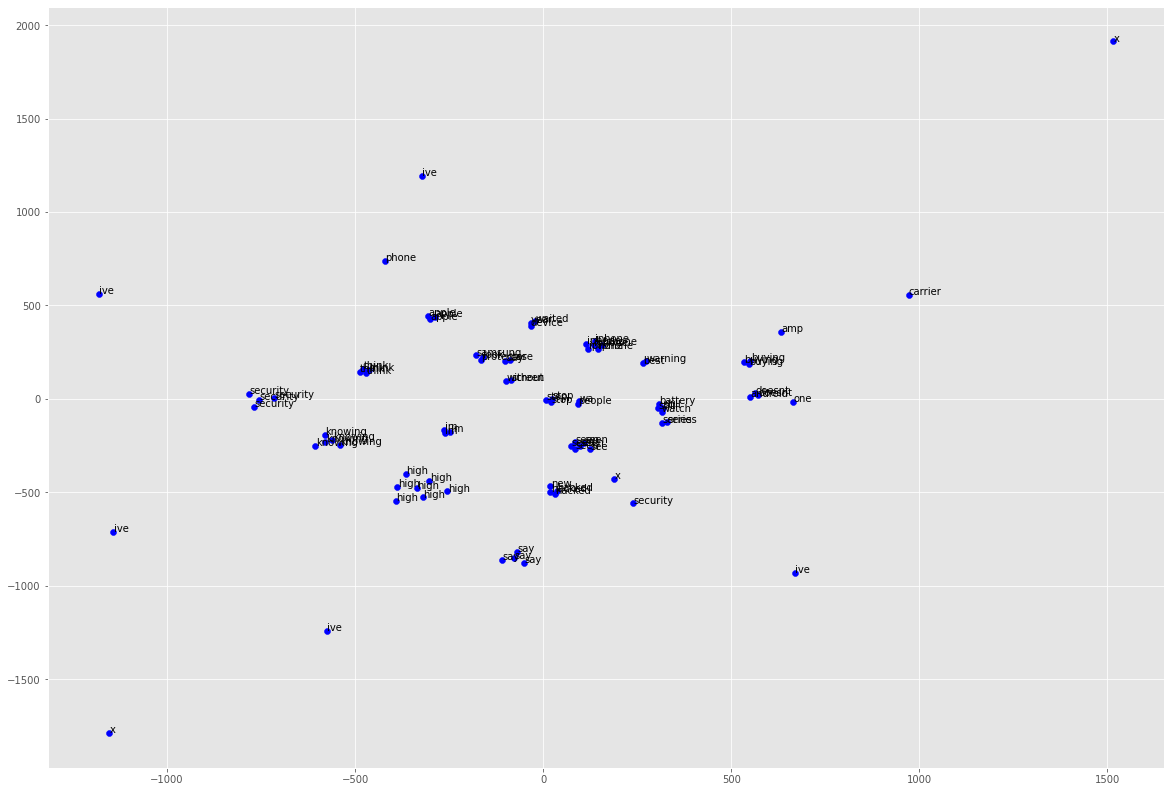

In [88]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 14))
plt.style.use('ggplot')

ax.scatter(T[:, 0], T[:, 1], c='blue')

for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    ax.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')
    
plt.show()

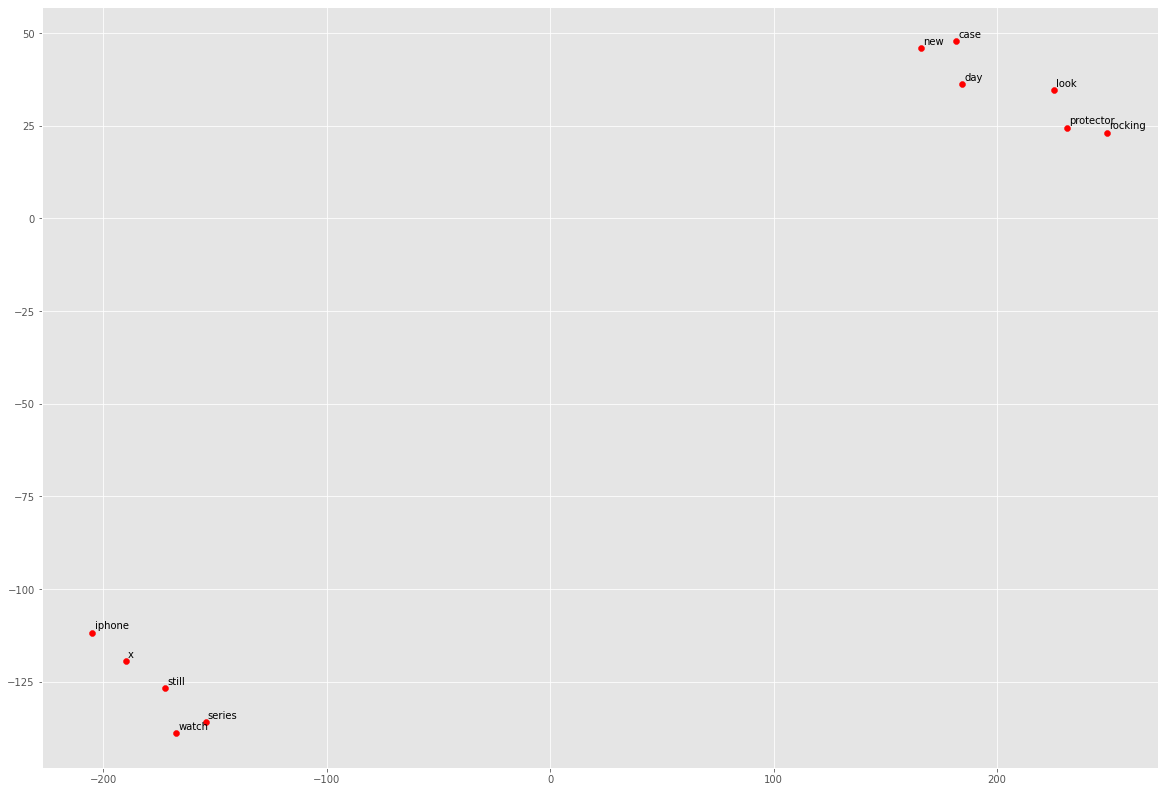

In [85]:
fig, ax = plt.subplots(figsize=(20, 14))
plt.style.use('ggplot')
ax.scatter(T2[:, 0], T2[:, 1], c='red')
for label, x, y in zip(labels2, T2[:, 0], T2[:, 1]):
    ax.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')